# Code #1:
## Please find the notes at the end


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets, transforms
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
# Train data transformation

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                    ])

# Test data transformations

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                    ])

In [3]:
# download dataset and create train and test sets separately

train = datasets.MNIST(root = '../data', train = True, download = True, transform= train_transforms)

test = datasets.MNIST(root = '../data', train = False, download = True, transform=test_transforms)

In [4]:
# set seed values
torch.manual_seed(400)

In [5]:
cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(400)
    
device = torch.device("cuda" if cuda else "cpu")

In [6]:
dataloader_args = dict(shuffle=True, batch_size = 64, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size = 64)

In [7]:
#Dataloaders

train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)

test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

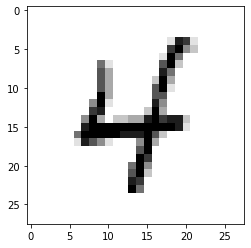

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')

In [9]:
train_losses = []
train_accuracy = []

test_losses = []
test_accuracy = []

In [10]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None):
          
    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = f.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step foe the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)
      
      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      print('Train metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('Test metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [11]:
class Network_1(nn.Module):        
    def __init__(self):
        
        super().__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()) #input = 28, output = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()) #input = 28, output = 26, RF = 5
        
        # TRANSITION BLOCK 1, let's have a mix of channels without extracting features here
        self.convblock3 = nn.Sequential(
            nn.Conv2d(32, 14, 1, padding=0, bias=False),
            nn.ReLU()) #input = 28, output = 26, RF = 5
        
        self.pool1 = nn.MaxPool2d(2, 2) #input = 26, output = 13, RF = 10

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(14, 24, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24)) #input = 13, output = 11, RF = 12

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(24, 24, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24)) #input = 11, output = 9, RF = 14
        
        # Transition via 1x1 to reduce params and allow selection of relevant channels for next 3x3 layer to extract features
        self.convblock6 = nn.Sequential(
            nn.Conv2d(24, 12, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12)) #input = 9, output = 9, RF = 14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(12, 16, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)) #input = 9, output = 7, RF = 16
        
        self.avg = nn.AvgPool2d(7) # Average Pool layer to reduce dimensions and have a larger view for incoming dimensions to make a decision
        
        # Final layer with 1x1 to have 10 output channels
        self.convblock8 = nn.Sequential(
            nn.Conv2d(16, 10, 1, padding=0, bias=False)) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x) 
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [12]:
# check model summary
model = Network_1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 26, 26]           4,608
       BatchNorm2d-5           [-1, 32, 26, 26]              64
              ReLU-6           [-1, 32, 26, 26]               0
            Conv2d-7           [-1, 14, 26, 26]             448
              ReLU-8           [-1, 14, 26, 26]               0
         MaxPool2d-9           [-1, 14, 13, 13]               0
           Conv2d-10           [-1, 24, 11, 11]           3,024
             ReLU-11           [-1, 24, 11, 11]               0
      BatchNorm2d-12           [-1, 24, 11, 11]              48
           Conv2d-13             [-1, 24, 9, 9]           5,184
             ReLU-14             [-1, 2

In [13]:
# initialize the optimizer with model's parameters
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

# 
train_eval_model(model, train_loader, optimizer, device, epochs=15, test=True, test_loader=test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 938/938 [00:20<00:00, 45.81it/s]

Train metrics: accuracy: 55494/60000 (92.4900%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0659, accuracy: 9838/10000 (98.38000%)


 epoch num ================================= 2


100%|██████████| 938/938 [00:20<00:00, 46.73it/s]

Train metrics: accuracy: 58551/60000 (97.5850%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0622, accuracy: 9798/10000 (97.98000%)


 epoch num ================================= 3


100%|██████████| 938/938 [00:20<00:00, 46.41it/s]

Train metrics: accuracy: 59046/60000 (98.4100%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0329, accuracy: 9896/10000 (98.96000%)


 epoch num ================================= 4


100%|██████████| 938/938 [00:20<00:00, 46.71it/s]

Train metrics: accuracy: 59284/60000 (98.8067%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0390, accuracy: 9879/10000 (98.79000%)


 epoch num ================================= 5


100%|██████████| 938/938 [00:19<00:00, 47.73it/s]

Train metrics: accuracy: 59385/60000 (98.9750%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0314, accuracy: 9898/10000 (98.98000%)


 epoch num ================================= 6


100%|██████████| 938/938 [00:19<00:00, 46.94it/s]

Train metrics: accuracy: 59446/60000 (99.0767%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0365, accuracy: 9895/10000 (98.95000%)


 epoch num ================================= 7


100%|██████████| 938/938 [00:19<00:00, 47.51it/s]

Train metrics: accuracy: 59480/60000 (99.1333%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0290, accuracy: 9907/10000 (99.07000%)


 epoch num ================================= 8


100%|██████████| 938/938 [00:19<00:00, 47.01it/s]

Train metrics: accuracy: 59494/60000 (99.1567%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0284, accuracy: 9908/10000 (99.08000%)


 epoch num ================================= 9


100%|██████████| 938/938 [00:20<00:00, 46.40it/s]

Train metrics: accuracy: 59609/60000 (99.3483%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0419, accuracy: 9870/10000 (98.70000%)


 epoch num ================================= 10


100%|██████████| 938/938 [00:20<00:00, 46.30it/s]

Train metrics: accuracy: 59605/60000 (99.3417%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0359, accuracy: 9881/10000 (98.81000%)


 epoch num ================================= 11


100%|██████████| 938/938 [00:20<00:00, 45.93it/s]

Train metrics: accuracy: 59647/60000 (99.4117%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0271, accuracy: 9914/10000 (99.14000%)


 epoch num ================================= 12


100%|██████████| 938/938 [00:20<00:00, 46.43it/s]

Train metrics: accuracy: 59672/60000 (99.4533%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0336, accuracy: 9894/10000 (98.94000%)


 epoch num ================================= 13


100%|██████████| 938/938 [00:20<00:00, 45.51it/s]

Train metrics: accuracy: 59706/60000 (99.5100%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0277, accuracy: 9913/10000 (99.13000%)


 epoch num ================================= 14


100%|██████████| 938/938 [00:20<00:00, 45.97it/s]

Train metrics: accuracy: 59700/60000 (99.5000%)



  0%|          | 0/938 [00:00<?, ?it/s]

Test metrics: average loss: 0.0289, accuracy: 9918/10000 (99.18000%)


 epoch num ================================= 15


100%|██████████| 938/938 [00:20<00:00, 45.28it/s]

Train metrics: accuracy: 59732/60000 (99.5533%)


Test metrics: average loss: 0.0258, accuracy: 9918/10000 (99.18000%)



## Plotting the loss and accuracy values for both train and test metrics with epochs

Text(0.5, 1.0, 'Test Accuracy')

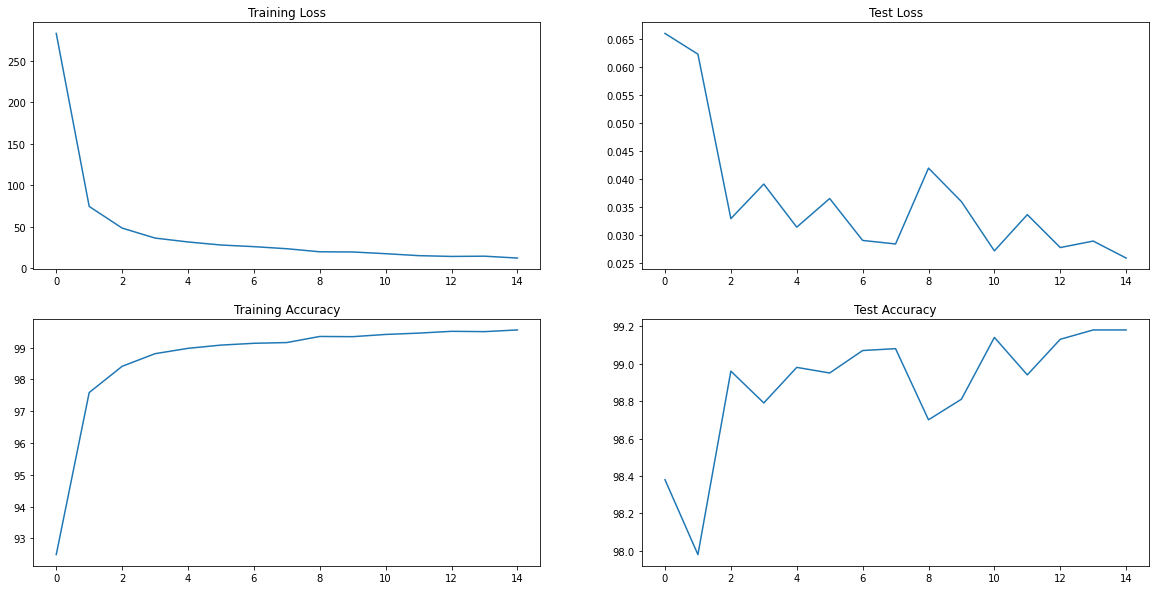

In [14]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")

# Code 1 Notes:

---------

## Target:

This attempt was to have a working yet very basic model. The approach was to stick with known way of increasing filters. But still maintaining the total parameters on lower spectrum without being finicky about it. The idea here was to have a fixed arrangement of layers and observe (and try to increase) the training capabilities of the network.

------

## Results:

> Total params:          15,832

> Total epochs:          15

> Last epoch accuracies: Train 99.55% ; Test 99.18%


`1)` Train accuracy starts with 92% and gradually crosses 99% mark in 6th epoch.

`2)` With increasing epochs and train accuracy, test accuracy hits 99% and is almost consistent from 11th epoch

`3)` Final train accuracy is good (99.5%+) and test accuracy is 99.18%

-------

## Analysis:
`1)` First experiment without BN was giving larger gap between 2 accuracies and lower test accuracy. Since have 3 codes to submit decided to add BN in 1st one.

`2)` Despite train acc. being high, test acc. lags behind with a considerable difference, which tantamounts to having some level of over-fitting.

`3)` As the train acc. already has crossed 99.5% mark, there is only a small room for further improvement for the network and to push test accuracy higher. More epochs would hardly make some difference as test accuracy started to saturate towards the end and was moving within 99.10 - 99.20 % range

`4)` Using 1x1 definitely helped not only in reducing number of params to an extent (although the aim was not that here
) as well as in achieving decent accuracy as it helped in _selection_ of important channels and merging them together instead of just performing feature extraction like 3x3.

`5)` Moving forward will include `Dropout` to help reduce gap between train and test accuracies. And will also experiment with basic `Data Augmentation` **but will add and experiment with 1 thing at a time !**

---

![](https://pbs.twimg.com/media/EegSVtOXkAAcI_l?format=jpg&name=small)